In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import   InceptionV3
from tensorflow.keras.applications import   ResNet50
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import  MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import cv2
import pathlib
import matplotlib as mpl

In [2]:
img_width = 225
img_height = 255
batch_size = 64
color = 3
dataset_folder = "Date Fruit"
classes_name = ['Aseel', 'Fasli Toto', 'Gajar', 'Kupro']

In [3]:
def Blurring(image):
    image = cv2.medianBlur(image,5)
    return image
def image_generator(dataset_folder):
    datagen = ImageDataGenerator( rescale=1/255, validation_split=0.2,
                               vertical_flip=True ,
                               horizontal_flip=True,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               rotation_range = 5, 
                               shear_range = 0.02,zoom_range = 0.02,
                               preprocessing_function = Blurring)
    train_generator = datagen.flow_from_directory(
      dataset_folder,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      subset='training')
    validation_generator = datagen.flow_from_directory(
      dataset_folder,
      target_size=(img_height, img_width),
      batch_size= batch_size,
      shuffle=False,
      class_mode='categorical',
      subset='validation')
    return [train_generator, validation_generator]

In [4]:
[training_dataset, validation_dataset] = image_generator(dataset_folder)

Found 2404 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [5]:
# Get class indices and classes
class_indices = training_dataset.class_indices
classes = training_dataset.classes
# Count number of images per class
class_counts = {class_name: np.sum(classes == class_index) for class_name, class_index in class_indices.items()}
print ('****************train************************************')
# Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

****************train************************************
Class 'Aseel': 396 images
Class 'Fasli Toto': 312 images
Class 'Gajar': 1048 images
Class 'Kupro': 648 images


In [6]:
# Get class indices and classes
class_indices = validation_dataset.class_indices
classes = validation_dataset.classes
# Count number of images per class
class_counts = {class_name: np.sum(classes == class_index) for class_name, class_index in class_indices.items()}
print ('****************test************************************')
# Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

****************test************************************
Class 'Aseel': 98 images
Class 'Fasli Toto': 78 images
Class 'Gajar': 262 images
Class 'Kupro': 162 images


In [7]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.layers import Input, Concatenate, Dense, Activation,Flatten,Dropout
model_1 = load_model('modelInception.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='Inception')
model_2 = load_model('modelResNet.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='ResNet')
model_3 = load_model('modelInceptionResNetV2.h5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='InceptionResNetV2')

model_4 = load_model('modelMobileNetV2.h5')
model_4 = Model(inputs=model_4.inputs,
                outputs=model_4.outputs,
                name='MobileNetV2')

models = [model_1, model_2,model_3,model_4 ]

model_1.trainable = False
model_2.trainable = False
model_3.trainable = False
model_4.trainable = False

# Create the input layer
model_input = Input(shape=(255, 225,3))

# Pass the input through the base models
model_1_output = model_1 (model_input)
model_2_output = model_2 (model_input)
model_3_output = model_3 (model_input)
model_4_output = model_4 (model_input)
# Concatenate the outputs of the base models
combined_output = Concatenate()([model_1_output, model_2_output,model_3_output,model_4_output])

# Add fully connected layers
x = Flatten()(combined_output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(18, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(len(classes_name), activation='softmax')(x)

# Create the stacking ensemble model
stacking_model = Model(inputs=model_input, outputs=output_layer)


In [8]:
me = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

In [9]:
base_learning_rate = 0.01
stacking_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=me)

In [10]:
call_1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
callbacks = [call_1]

In [11]:
epochs=50
historyENSEMBLING=stacking_model.fit(
training_dataset,
  epochs=epochs,
  callbacks = callbacks,
  batch_size = batch_size
)


Epoch 1/50

38/38 [==============================] - 460s 12s/step - loss: 1.2054 - tp: 1652.0000 - fp: 77.0000 - tn: 7135.0000 - fn: 752.0000 - accuracy: 0.9138 - precision: 0.9555 - recall: 0.6872 - auc: 0.9655
Epoch 2/50
38/38 [==============================] - 441s 12s/step - loss: 0.8493 - tp: 2305.0000 - fp: 75.0000 - tn: 7137.0000 - fn: 99.0000 - accuracy: 0.9819 - precision: 0.9685 - recall: 0.9588 - auc: 0.9954
Epoch 3/50
38/38 [==============================] - 439s 12s/step - loss: 0.8121 - tp: 2329.0000 - fp: 57.0000 - tn: 7155.0000 - fn: 75.0000 - accuracy: 0.9863 - precision: 0.9761 - recall: 0.9688 - auc: 0.9968
Epoch 4/50
38/38 [==============================] - 461s 12s/step - loss: 0.8082 - tp: 2330.0000 - fp: 56.0000 - tn: 7156.0000 - fn: 74.0000 - accuracy: 0.9865 - precision: 0.9765 - recall: 0.9692 - auc: 0.9976
Epoch 5/50
38/38 [==============================] - 466s 12s/step - loss: 0.8151 - tp: 2333.0000 - fp: 64.0000 - tn: 7148.0000 - fn: 71.0000 - accuracy: 0

In [12]:
def drawing(p1, p2, p3, p4):
  a = p1[0]
  b = p2[0]
  c = p3[0]
  d = p4[0]
  plt.rcParams["figure.figsize"] = (20,4)
  mpl.style.use('seaborn')
  plt.plot(a,'blue', label=p1[1])
  plt.plot(b,'orange', label=p2[1])
  plt.plot(c,'red', label=p3[1])
  plt.plot(d,'green', label=p4[1])
  plt.legend()

C:\Users\Elite\AppData\Local\Temp\ipykernel_13700\354503818.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


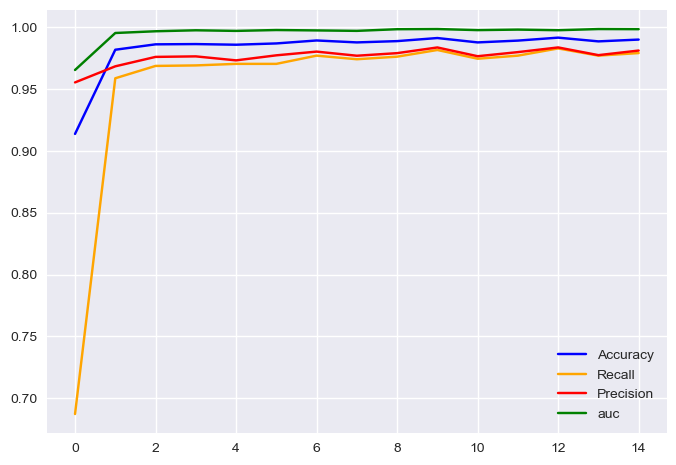

In [13]:
drawing(
    [historyENSEMBLING.history['accuracy'], 'Accuracy'],
    [historyENSEMBLING.history['recall'], 'Recall'],
    [historyENSEMBLING.history['precision'], 'Precision'],
    [historyENSEMBLING.history['auc'], 'auc']
)

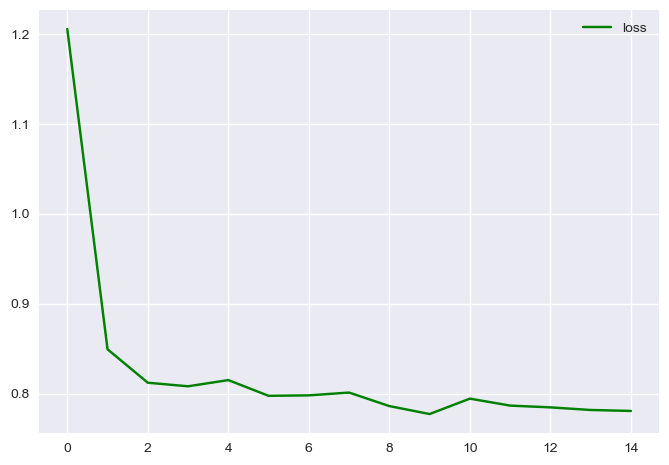

In [14]:
plt.plot(historyENSEMBLING.history['loss'],'green', label="loss")
plt.legend()

In [15]:
stacking_model.evaluate(validation_dataset,batch_size = validation_dataset.batch_size ,steps = validation_dataset.n // validation_dataset.batch_size)

9/9 [==============================] - 112s 11s/step - loss: 0.7747 - tp: 565.0000 - fp: 11.0000 - tn: 1717.0000 - fn: 11.0000 - accuracy: 0.9905 - precision: 0.9809 - recall: 0.9809 - auc: 0.9973


[0.7746891379356384,
 565.0,
 11.0,
 1717.0,
 11.0,
 0.9904513955116272,
 0.9809027910232544,
 0.9809027910232544,
 0.9973440766334534]

In [16]:
validation_dataset.reset()

In [17]:
Y_pred =stacking_model.predict(validation_dataset,  workers=1)

10/10 [==============================] - 126s 12s/step


In [18]:
y_pred = np.argmax(Y_pred ,  axis = 1)

In [19]:
res = tf.math.confusion_matrix(y_pred,validation_dataset.classes).numpy()
confusion_matrix = pd.DataFrame(res,
                     index = classes_name,
                     columns = classes_name)
confusion_matrix

,Aseel,Fasli Toto,Gajar,Kupro
Aseel,98,1,0,0
Fasli Toto,0,73,0,0
Gajar,0,4,262,0
Kupro,0,0,0,162


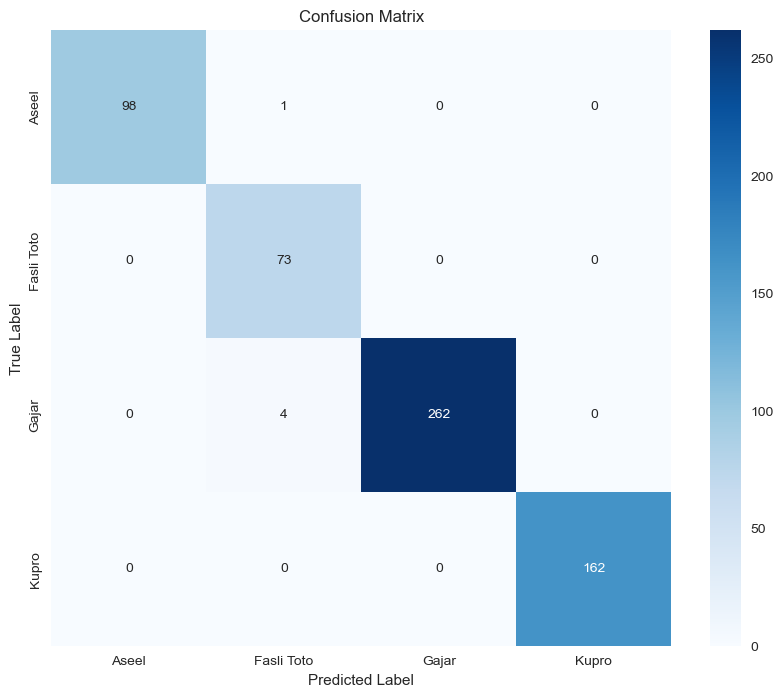

In [20]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
classifi_report = classification_report(validation_dataset.classes, y_pred,target_names = classes_name)
print(classifi_report)

              precision    recall  f1-score   support

       Aseel       0.99      1.00      0.99        98
  Fasli Toto       1.00      0.94      0.97        78
       Gajar       0.98      1.00      0.99       262
       Kupro       1.00      1.00      1.00       162

    accuracy                           0.99       600
   macro avg       0.99      0.98      0.99       600
weighted avg       0.99      0.99      0.99       600

